In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import concurrent.futures

## Group Assignment
### Team Number: 11
### Team Member Names: Richard Yang, William Zhang, Soham Basu
### Team Strategy Chosen: SAFE

In [2]:
# Extract all the tickers from the csv file
# Use loop to append tickers into a empty list called tickers_lst one by one
givenTickers = pd.read_csv('Tickers.csv')
tickers_lst = []
for i in range(len(givenTickers)):
    tickers_lst.append(givenTickers.iloc[i, 0])


# Function outputs true if the stock is in USD, otherwise false
# The parameter is a string representing the ticker name
def currencyUSD(stock):
    if stock.info['currency'] == 'USD':
        return True
    else:
        return False

# Function outputs true if the stock has a daily average volume of at least 10000 shares in a given time period, otherwise false
# The first parameter is a string representing the ticker name, the second and third parameter specify the time period
def volume10000(stock, start_date, end_date):
    hist = stock.history(start=start_date, end=end_date)
    if hist['Volume'].mean() >= 10000:
        return True
    else:
        return False

In [3]:
# Create an empty list filterTickers, then filter out stocks that meet the following requirements:
# 1. It is a US listed stock
# 2. Has a daily average volume of at least 10000 shares from July 02, 2021 to October 22, 2021
filterTickers = []
start_date = '2021-07-02'
end_date = '2021-10-22'

# The parameter is a string
# This function will firstly check if the ticker is valid or not(we use .info['regularMarketPrice'] to do that)
# Once the ticker is valid, the function will check whether the stock meet BOTH two requirements stated above
# If the ticker meets all the requriements, the function will append this ticker into "filterTicker" list


def filterStocks(ticker):
    stock = yf.Ticker(ticker)
    if stock.info['regularMarketPrice'] is not None:
        if currencyUSD(stock) & volume10000(stock, start_date, end_date):
            filterTickers.append(ticker)

#NEW CODE -- Used for threading 
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(filterStocks, tickers_lst)

In [4]:
#NEW CODE
#Removes duplicates in list of tickers
filterTickers = list(dict.fromkeys(filterTickers))

Volatility/Standard Deviation: 

Weight: 45% 

Volatility maps how much a stock deviates over a certain period. The stocks that have lower volatility deviate less. The less a stock deviates, the safer it is. The reason volatility has such a high weighting in our overall score is because of its ability to weed out the riskiest stocks from our portfolio by assigning them a low score. We were also aiming to find a balance between volatility in the short-term and long-term. The pandemic has had a major impact on stock prices over the last 2 years, which is why we also wanted to look at historical data over the last 10 years to get a bigger picture. That is why our final volatility calculates a weighted average of the volatility over the last 2 years, worth 25%, and the volatility over the last 10 years, worth 75% of the final volatility.  

 

Sharpe Ratio: 

Weight: 40% 

Sharpe ratio is a way to measure how much return an investor can get per unit of risk. It takes both the average return and standard deviation into account. This allows us to look at whether the stock is worth buying. One potential dilemma with the sharpe ratio is that a stock with a low return and volatility has the same sharpe ratio as a stock with a high return and high volatility. Since we are trying to build a portfolio of safe stocks, it is important that we get rid of most stocks with high volatilities. In our portfolio, we can do this by giving standard deviation a high weighting, allowing it to weed out the riskiest of stocks. Once again, in order to get a balance between sharpe ratio in the short-term and sharpe ratio in the long term, we calculated mean return using a weighted average of the return over the last 2 years, worth 25%, and the return over the last 10 years, worth 75%.  

 

Covariance: 

Weight: 10% 

We choose stocks which have high covariance with S&P 500. This is to find stocks that basically follow the market trend. That means the stocks do not have high non-systematic risk. Since the market index like S&P 500 normally has low volatility, stocks chosen based on this criterion will be safe.  

 

Moving Price Average: 

Weight: 5% 

The reason for looking at the Two Hundred Moving Price Average is simply to get another indicator to see how safe the stock is. The closer a stock is to its moving price average, the more likely that it is a safer stock as it likely deviates less than other, more riskier stocks. Of course, a really risky stock could just happen to be very close to its moving price average; however, when combined with other indicators such as volatility and covariance, moving price average is a good way of finding safe stocks.  

 

We wanted to use a variety of indicators such as volatility, sharpe ratio, covariance with the S&P 500 index, and moving price average. In addition, the data used to calculate many of these indicators aimed to strike a balance between the short-term stock history and long-term stock history. This helps to diversify our indicators and allows us to pick better stocks. Say for example, a stock gets a poor correlation with the S&P 500. If other factors such as volatility and moving price average show that the stock is safe, then it has a high chance of still being included in our portfolio. We decided the weights for each indicator based on how well each indicator can predict how safe a stock is. Multiple portfolios have been generated using different weights for the indicators, and this was found to be the optimal weighting. 

In [5]:
# uses factors such as a stock's volatility/standard deviation, sharpe ratio, covariance, and moving price average
# to assign each stock a score
# the higher the score, the safer the stock is and the better it is for our portfolio
def calculateScore(stockInfo, stockHist_2, stockHist_10, price, indexHist):

    # finds volatility (standard deviation) using the daily log returns in terms of percentage, 
    # and finds the volatility as an annual percentage
    stockHist_2['Log returns'] = np.log(stockHist_2['Close'] / stockHist_2['Close'].shift())
    volatility_2 = stockHist_2['Log returns'].std() * 252 ** 0.5
    stockHist_10['Log returns'] = np.log(stockHist_10['Close'] / stockHist_10['Close'].shift())
    volatility_10 = stockHist_10['Log returns'].std() * 252 ** 0.5
    # calculates a weighted average for volatility based on the average volatility over the last 2 years
    # and over the last 10 years
    # volatility over last 2 years: 25%, volatility over last 10 years: 75%
    volatility = ((volatility_2 * 0.25) + (volatility_10 * 0.75))
    
    # calculates the average return of the stock
    meanReturn_2 = stockHist_2['Log returns'].mean() * 252
    meanReturn_10 = stockHist_10['Log returns'].mean() * 252
    # finds a weighted average for return based on the average return over the last 2 years and 
    # over the last 10 years
    # return over last 2 years: 25%, return over last 10 years: 75%
    meanReturn = (meanReturn_2 * 0.25) + (meanReturn_10 * 0.75)
    # uses mean return and volatility to calculate sharpe ratio
    # assumes risk-free rate of return is 0
    sharpeRatio = meanReturn / volatility

    # finds covariance by comparing the stock to the S&P 500 index using data over the last 10 years
    # organizes price data
    prices = pd.DataFrame(stockHist_10['Close'])
    prices.columns = ['Stock']
    prices['index'] = indexHist['Close']
    # calculates stock's correlation to S&P 500 index
    covariance = prices.corr()
    corr = float(covariance.iloc[0, 1])

    # calculates the stock's percent difference from its Two Hundred Day Moving Average to its current price
    price_average = stockInfo["twoHundredDayAverage"]
    percent_difference = (price - price_average) / price_average

    # uses all 4 factors to assign a final score to each ticker:
    # Volatility: 45%
    # Sharpe Ratio: 40%
    # Correlation: 10%
    # Moving Day Price Average: 5%
    score = ((1 - volatility) * 0.45) + (sharpeRatio * 0.4) + (corr * 0.1) + ((1 - percent_difference) * 0.05)
    return score

In [6]:
score_lst = []
price_lst = []

# gets data for each ticker and S&P 500 in order to calculate a score for each stock
def getStockData(ticker):
    # finds stock data over last 2 and 10 years respectively 
    stock = yf.Ticker(ticker)
    stockInfo = stock.info
    stockHist_2 = stock.history(period="2y")
    stockHist_10 = stock.history(period="10y")
    # gets the stock's current price and appends it to a list of prices
    price = stock.history(start="2021-11-26", end="2021-11-27")
    
    ### NEW CODE(price["Close"] is a dataframe, so we use a float to convert it to a number)
    price = float(price["Close"])
    
    price_lst.append(price)
    # finds data for S&P 500 index over last 10 years
    index = yf.Ticker('^GSPC')
    indexHist = index.history(period="10y")  # Time period used to calculate the covariance
    # calculates a final score for each stock and appends it to a list of scores
    score_lst.append(calculateScore(stockInfo, stockHist_2, stockHist_10, price, indexHist))

for ticker in filterTickers:
    getStockData(ticker)

In [7]:
# Already get one list of tickers(filterTickers), and one list of score(score_lst), and one list of current prices of those stocks
# We want to find the 20 stocks with the highest score, and find their corresponding current price and give them the weight
# create one list to store the stock with highest score to the stock with the 20th highest score (chosen_tickers)
# the weight should be (6.9%+6.7%+ ...3.3%+3.1%=100%), corresponding to stocks of highest score to stocks of lowest score(among 20 stocks we choose)
# In list "chosen_weights", there will be a list of numbers from 0.069, to 0.031(20 numbers)
# Then get the corresponding current price for those 20 stocks

chosen_tickers = []
chosen_weights = []
chosen_prices = []
chosen_scores = []
maxWeight=0.069

#NEW CODE -- Just Variables
#saving these values to a different variable as we will need to drop some of the elements
save_score_lst=score_lst.copy()
save_price_lst=price_lst.copy()
save_filterTickers=filterTickers.copy()

for i in range(20):
    max_score = max(score_lst)
    max_index = score_lst.index(max_score)
    chosen_tickers.append(filterTickers[max_index])
    chosen_weights.append(maxWeight)
    chosen_prices.append(price_lst[max_index])
    chosen_scores.append(score_lst[max_index])
    score_lst.pop(max_index)
    filterTickers.pop(max_index)
    price_lst.pop(max_index)
    maxWeight -= 0.002
    maxWeight = round(maxWeight, 3)

In [8]:
save_score_lst

[-0.7116548051316365,
 0.6275531458620517,
 0.8300663471692176,
 0.7682272531657961,
 -0.3486548803092665,
 0.5996640028954461,
 0.7964501504718483,
 0.6120931725881906,
 0.6739880426948244,
 0.7515579444092831,
 0.6346436496132126,
 0.7035490723969852,
 0.8422990901460922,
 0.6929852303755425,
 0.6379486894400106,
 0.5875895544515148,
 0.9358165421658273,
 0.6701872213210425,
 0.41137096074376406,
 -0.3041133832319472,
 0.7700994901392277,
 0.22038162881922976,
 0.10963726117105799,
 0.6919099693112162,
 0.7091724481092008,
 0.6276256075132944,
 0.37075967603299953]

In [9]:
# Starting value of $100,000
initial_investment=100000
# Create a dataframe called FinalPortfolio by using the list chosen_tickers
FinalPortfolio = pd.DataFrame(chosen_tickers)
# Change the column name
FinalPortfolio.columns=["Ticker"]
# Add another column, the current price of each stock, into the dataframe
FinalPortfolio["Price"]=chosen_prices
chosen_weights=list(chosen_weights)
FinalPortfolio['Shares']=0
FinalPortfolio
for i in range(len(FinalPortfolio['Price'])):
    FinalPortfolio["Shares"].iloc[i]=initial_investment/FinalPortfolio["Price"].iloc[i]*chosen_weights[i]
FinalPortfolio['Value']=FinalPortfolio["Shares"]*FinalPortfolio["Price"]
FinalPortfolio['Weight']=chosen_weights
FinalPortfolio.index = np.arange(1,len(FinalPortfolio)+1)

/Users/richa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
#Creating variable for total portfoliio weight to confirm the total weight is 100
totalWeight=FinalPortfolio["Weight"].sum()
print("Your total overall portfolio weighting is " + str(totalWeight))
#creating variable for overall portfolio value to confirm it is $100000
totalValue=FinalPortfolio['Value'].sum()
print("Your total overall value weighting is $" + str(totalValue))

Your total overall portfolio weighting is 1.0
Your total overall value weighting is $100000.0


In [11]:
######## Creating the portfolio 
# The input is a DataFrame containing columns Ticker, Price, Shares, Value, Weight(eg FinalPortfolio)
# The function outputs another DataFrame containing only the portfolio value created by the input stocks and back in 3 years
# We make the initial investment to be $100,000 three years ago, and track the portfolio value change back in the past 3 years
def portfoliovalue(finalportfolio):
    PortfolioHistory=pd.DataFrame()
    PortfolioValue=pd.DataFrame()
    shares=0
    for i in range(len(finalportfolio)):
        stock = yf.Ticker(finalportfolio.iloc[i, 0])
        stockHist_3=stock.history(period='3y').resample('MS').first()
        shares=initial_investment/stockHist_3.Close[0]*chosen_weights[i]
        PortfolioHistory[finalportfolio.iloc[i, 0]] = stockHist_3.Close*shares
    PortfolioValue["Value"] = PortfolioHistory.sum(axis=1)
    return PortfolioValue

In [12]:
# Find the 10 stocks with the lowest score and create a dataframe for it(the same as FinalPortfolio)

min_chosen_tickers = []
min_chosen_prices = []
min_chosen_weight = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

#variable names were replaced with new variables as referenced above as new code
for i in range(10):
    min_score = min(save_score_lst)
    min_index = save_score_lst.index(min_score)
    min_chosen_tickers.append(save_filterTickers[min_index])
    min_chosen_prices.append(save_price_lst[min_index])
    save_score_lst.pop(min_index)
    save_filterTickers.pop(min_index)
    save_price_lst.pop(min_index)

# Starting value of $100,000
initial_investment=100000
# Create a dataframe called riskyPortfolio by using the list chosen_tickers
riskyPortfolio = pd.DataFrame(min_chosen_tickers)
# Change the column name
riskyPortfolio.columns=["Ticker"]
# Add another column, the current price of each stock, into the dataframe
riskyPortfolio["Price"]=min_chosen_prices
riskyPortfolio['Shares']=0
min_chosen_weight = list(min_chosen_weight)
for i in range(len(riskyPortfolio['Price'])):
    riskyPortfolio["Shares"].iloc[i]=initial_investment/riskyPortfolio["Price"].iloc[i]*min_chosen_weight[i]
riskyPortfolio['Value']=riskyPortfolio["Shares"]*riskyPortfolio["Price"]
riskyPortfolio['Weight']=min_chosen_weight
riskyPortfolio.index = np.arange(1,len(riskyPortfolio)+1)

Our portfolio, consisting of the stocks with the highest 20 scores, focuses on maintaining a low volatility/standard deviation as that indicator makes up 45% of our portfolio and has further influence in  the calculation of the sharpe ratio. Therefore, as the data proves, our portfolio has a much lower volatility than the ten worst performing stocks in the list of tickers, calculated based off our four indicators for safe stocks. In addition our sharp ratio is much higher for our Final Portfolio compared to the portfolio of the stocks with the ten lowest scores due to factoring the sharpe ratio values into our model as can be seen below.

In [13]:
Standard_deviation_FinalPortfolio = portfoliovalue(FinalPortfolio).pct_change().std()
Sharpe_ratio_FinalPortfolio = portfoliovalue(FinalPortfolio).pct_change().mean() / portfoliovalue(FinalPortfolio).pct_change().std()
print("For the FinalPortfolio, the standard deviation is",float(Standard_deviation_FinalPortfolio),", and the Sharpe ratio is", float(Sharpe_ratio_FinalPortfolio),".")


For the FinalPortfolio, the standard deviation is 0.06466397903347028 , and the Sharpe ratio is 0.4056279678902342 .


In [14]:
Standard_deviation_riskyPortfolio = portfoliovalue(riskyPortfolio).pct_change().std()
Sharpe_ratio_riskyPortfolio = portfoliovalue(riskyPortfolio).pct_change().mean() / portfoliovalue(riskyPortfolio).pct_change().std()
print("For a riskier portfolio with equal weightings for the stocks with the 10 lowest scores, the standard deviation is",float(Standard_deviation_riskyPortfolio), ", and the Sharpe ratio is", float(Sharpe_ratio_riskyPortfolio),".")

For a riskier portfolio with equal weightings for the stocks with the 10 lowest scores, the standard deviation is 0.07865883753070432 , and the Sharpe ratio is -0.30243790815385313 .


We can also check the standard deviation and Sharpe ratio of S&P 500 as benchmarks.

In [15]:
SP500 = yf.Ticker('^GSPC')
SP500hist = SP500.history(period='3y').resample('MS').first()

Standard_deviation_SP500hist = SP500hist.Close.pct_change().std()
Sharpe_ratio_SP500hist = SP500hist.Close.pct_change().mean()/SP500hist.Close.pct_change().std()
print("For the S&P 500, the standard deviation is",float(Standard_deviation_SP500hist),", and the Sharpe ratio is", float(Sharpe_ratio_SP500hist),".")

For the S&P 500, the standard deviation is 0.057011078296065894 , and the Sharpe ratio is 0.32782877832348484 .


In [16]:
#calculating the beta
MarketIndex='^GSPC' #This is the symbol yfinance uses for the S&P 500
Ticker2 = yf.Ticker(MarketIndex)

#putting start and end date for getting s and p 500
start_date = '2017-01-01'
end_date = '2021-11-26'

MarketIndex_hist = Ticker2.history(start=start_date, end=end_date)
MarketIndex_hist= MarketIndex_hist.resample('MS').first()
#putting value/price of s and p 500 and final portfolio in one dataframe
prices = pd.DataFrame(portfoliovalue(FinalPortfolio)['Value'])
prices.columns = ["Final Portfolio"]
prices[MarketIndex] = MarketIndex_hist['Close']
prices.drop(index=prices.index[0], inplace=True)

#calculating percentage change and dropping the first value
monthly_returns=prices.resample('MS').ffill().pct_change()
monthly_returns.drop(index=monthly_returns.index[0], inplace=True)

#calculating the market variance 
MarketVar= monthly_returns[MarketIndex].var()


#calculating beta by taking a covariance 
Beta=monthly_returns.cov()/MarketVar
print("Beta:")
print(Beta)


print('The Final Portfolio Beta is: ', Beta.iat[0,1])
print('The Beta of the Market is: ', Beta.iat[1,1])

Beta:
                 Final Portfolio     ^GSPC
Final Portfolio         1.325158  1.077987
^GSPC                   1.077987  1.000000
The Final Portfolio Beta is:  1.0779870047681888
The Beta of the Market is:  0.9999999999999998


Graph for correlation:  

This is an example of a stock and its correlation with the S and P 500 in our portfolio. Based on its movements, it seems to be positively correlated with the S and P 500 although not completely. Stocks with similar trajectories to the S and P 500’s movements may suggest that they are safer and less volatile as it has similar trends with the index.  

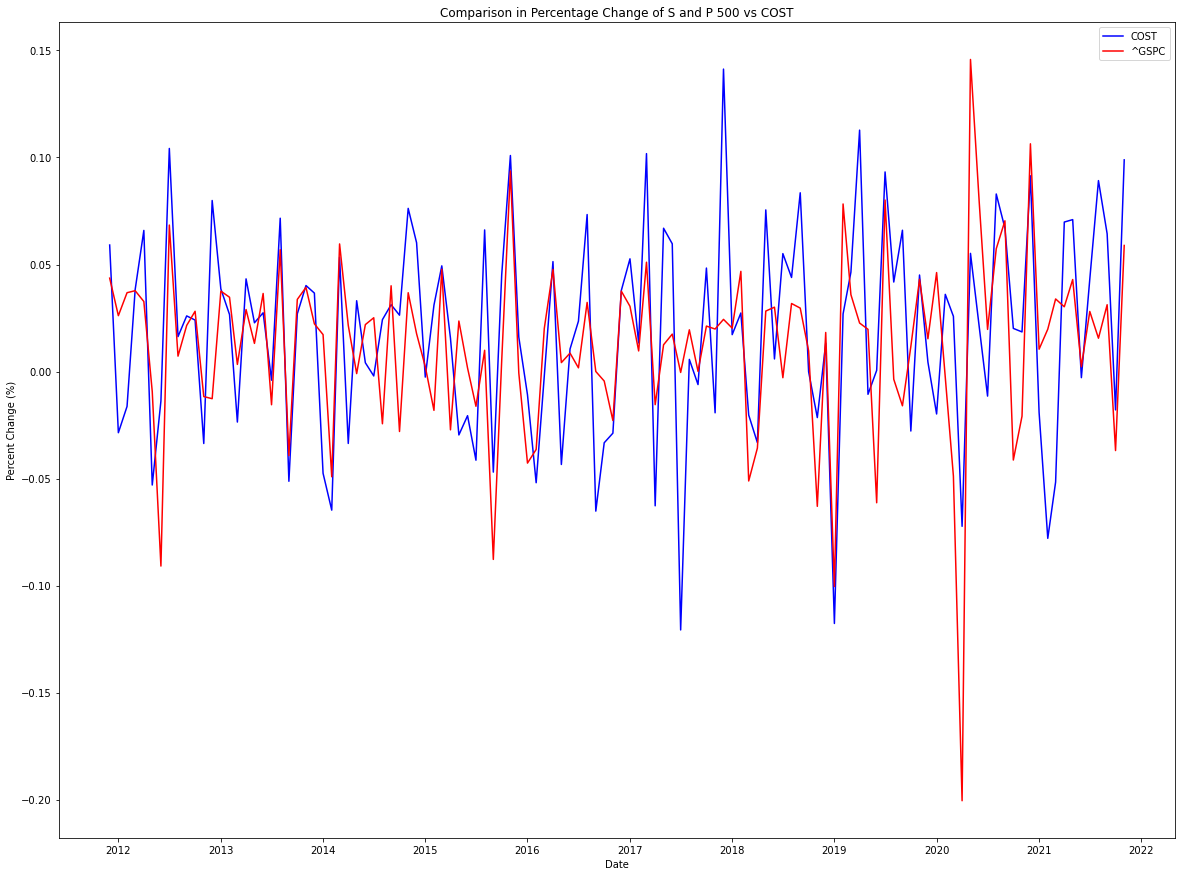

Correlation:
           COST     ^GSPC
COST   1.000000  0.560694
^GSPC  0.560694  1.000000


In [17]:
# Example of correlation between a stock in our portfolio and S&P 500
Stock1=chosen_tickers[0]
Stock2='^GSPC'
Ticker1 = yf.Ticker(Stock1)
Ticker2 = yf.Ticker(Stock2)

# Look at past 10 years
start_date = '2011-11-26'
end_date = '2021-11-26'

#get stock history
Stock1_hist = Ticker1.history(start=start_date, end=end_date)
Stock2_hist = Ticker2.history(start=start_date, end=end_date)

#get close prices
prices = pd.DataFrame(Stock1_hist['Close'])
prices.columns = [Stock1]
prices[Stock2] = Stock2_hist['Close']
prices.head()

#Calculate the monthly returns from the price dataFrame.
monthly_returns=prices.resample('MS').first().pct_change()
monthly_returns.drop(index=monthly_returns.index[0], inplace=True)
monthly_returns.head()

#plot graph
plt.figure(figsize=(20,15))

#plot the lines
plt.plot(monthly_returns.index,monthly_returns[Stock1], color='b', label=Stock1)
plt.plot(monthly_returns.index,monthly_returns[Stock2], color='r', label=Stock2)

#legend
plt.legend(loc='best')

#titles and labels
plt.title("Comparison in Percentage Change of S and P 500 vs " + str(Stock1))
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')

plt.show()


# create new cell
print('Correlation:')
print(monthly_returns.corr())

Graph for overall portfolio: 

As you can see our portfolio generally has had a similar trend compared to the S and P 500 in the past 3 years, suggesting that our portfolio is quite safe with most of non-systematic risk removed. It supports our constructed models in creating a safe portfolio. Generally the growth is overall quite smooth with very little abrupt movements. 

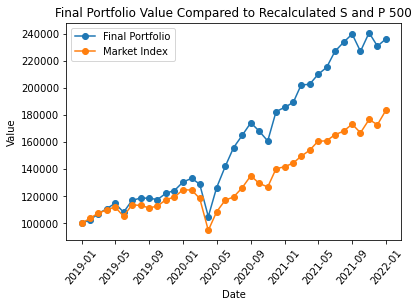

In [18]:
#graphing our final portfolio vs S and P 500 vs a portfolio containing the 10 stocks with the lowest scores

#Market index value recalculated with initial investment
MarketIndex_hist=Ticker2.history(period='3y').resample('MS').first()
MarketIndexShares=initial_investment/MarketIndex_hist.Close[0]
#History for recalculated shares of market index
MarketIndexNewHist=pd.DataFrame(MarketIndex_hist.Close*MarketIndexShares)
MarketIndexNewHist.columns=["Value"]

#creating the graphs
plt.plot(portfoliovalue(FinalPortfolio).index, portfoliovalue(FinalPortfolio)['Value'], marker='o', label='Final Portfolio')
plt.plot(MarketIndexNewHist.index, MarketIndexNewHist['Value'], marker='o', label='Market Index')
#labels
plt.title('Final Portfolio Value Compared to Recalculated S and P 500')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=50)
#legend
plt.legend(loc='best')
plt.show()

In [19]:
FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,COST,546.130005,12.634354,6900.0,0.069
2,GOOG,2856.120117,2.345840,6700.0,0.067
3,AMZN,3504.560059,1.854726,6500.0,0.065
4,LOW,247.690002,25.435019,6300.0,0.063
5,PEP,160.058426,38.111083,6100.0,0.061
6,ABBV,115.313416,51.164905,5900.0,0.059
7,SHOP,1576.699951,3.615146,5700.0,0.057
8,ORCL,91.988274,59.790230,5500.0,0.055
9,CMCSA,50.848225,104.231761,5300.0,0.053
10,CSCO,54.349735,93.836704,5100.0,0.051


In [20]:
Stocks=pd.DataFrame(FinalPortfolio["Ticker"])
Stocks["Shares"]=FinalPortfolio["Shares"]
Stocks

,Ticker,Shares
1,COST,12.634354
2,GOOG,2.345840
3,AMZN,1.854726
4,LOW,25.435019
5,PEP,38.111083
6,ABBV,51.164905
7,SHOP,3.615146
8,ORCL,59.790230
9,CMCSA,104.231761
10,CSCO,93.836704


In [21]:
portfolio_saved_file = Stocks.to_csv('Stocks_Group_11.csv')
portfolio_saved_file

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Richard Yang, Soham Basu, William Zhang

<font color='red'> We had originally encountered runtime issues with our submitted code. Therefore, we added threading by replacing our first for loop that produced the list filterTickers as a function (this does not change the actual output of the code, only speeds it up). 
    
The second thing we changed was to account for duplicate tickers in our tickers file, which we did by using the following line of code: "filterTickers = list(dict.fromkeys(filterTickers))".
    
The third thing we changed was the way that our price data was being outputted. Originally, it was outputting the price as a dataframe, which was causing problems calculating the values in score_lst. We have added one line of code that now outputs the closing price on November 26th as a number, which allows score_lst to produce its intended output (a list of numbers that are scores), rather than a list of dataframes. 
    
The fourth thing we changed was storing our original data before we pop the following variables in our for loop to find the top 20 scores in our portfolio (popped values in score_lst, price_lst, and filterTickers). We added new variables to store these original values: (save_score_lst, save_price_lst, save_filterTickers). We then changed our function for calculating the 10 stocks with the lowest score to use these new stored values instead (save_score_lst, save_price_lst, save_filterTickers).
</font> 